# 1. Подготовка

In [1]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.index.year.value_counts()

2018    26496
Name: datetime, dtype: int64

так как все происходит в одном году, нет надобности брать год в параметры обучения

In [5]:
def make_features(data):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

def get_features_and_targets(Data, max_lag, rolling_mean_size):
    data = Data.copy()
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    features_train = train.drop('num_orders', axis = 1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis = 1)
    target_test = test['num_orders']
    return features_train, target_train, features_test, target_test

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

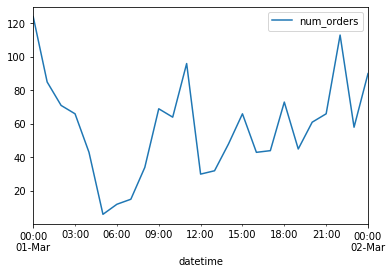

In [7]:
data['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot()

In [8]:
decomposed_week = seasonal_decompose(data['2018-03-05':'2018-03-12'])
decomposed_month = seasonal_decompose(data.resample('1D').sum()['2018-03-05':'2018-04-02'])

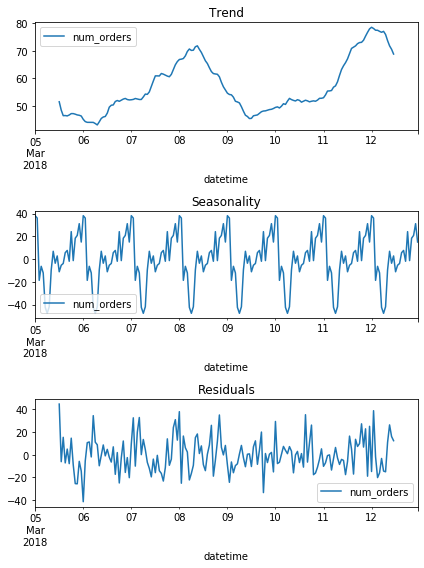

In [9]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

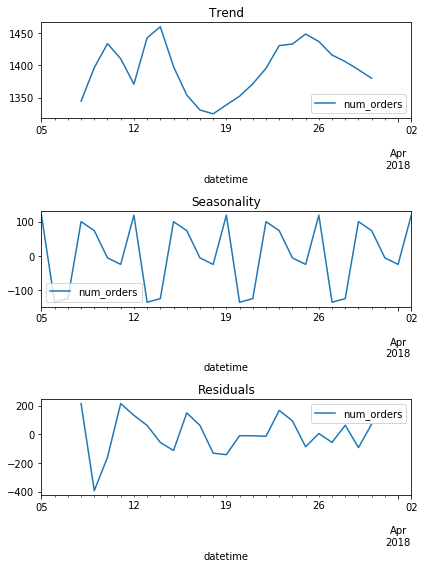

In [10]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_month.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_month.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_month.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Самая большая популярность такси в четверг и воскресенье, вторник и среда самы не прибыльные для такси дни.
К вечеру количество заказов возростает часов до 2х ночи, после чего резко падает.

[168, 504, 840, 1176]

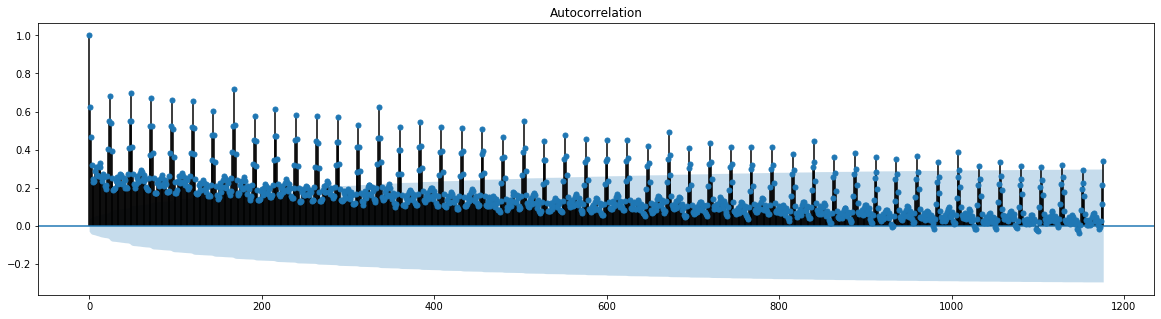

In [11]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
acf = plot_acf(data['num_orders'], lags=(1176), ax=ax)
picks = [168*i for i in range(1,9,2)]
picks

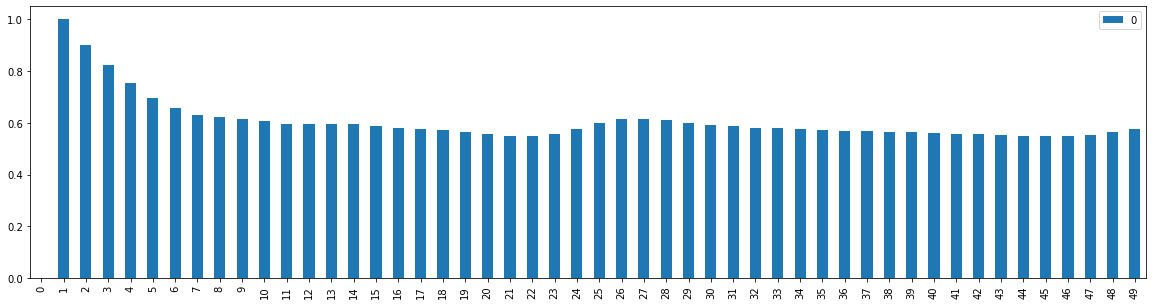

In [12]:
def roll(rolling):
    lis = {}
    for i in range(rolling):
        cor = data['num_orders'].corr(data['num_orders'].rolling(i).mean())
        lis[i] = cor
    lis = pd.DataFrame(data = lis.values(), index = lis.keys())
    lis.plot(kind = 'bar',figsize=(20,5))
roll(50)

# 3. Обучение

In [13]:
def search(model, parametrs):
    grid = GridSearchCV(model, parametrs, cv = 2,iid = False)
    score = {}
    for i in picks:
        for d in range(1, 5, 1):
            features_train, target_train, features_valid, target_valid = get_features_and_targets(data, i,d)
            score[cross_val_score(grid, features_valid, target_valid, cv=3).mean()] = (i,d)
    i, d = score[max(score.keys())]
    features_train, target_train, features_valid, target_valid = get_features_and_targets(data, i,d)
    grid.fit(features_valid, target_valid)
    return i,d, grid.best_params_
def fast_search(model, parametrs):
    grid = GridSearchCV(model, parametrs, cv = 2,iid = False)
    score = {}
    for i in picks:
        for d in range(1, 5, 1):
            features_train, target_train, features_valid, target_valid = get_features_and_targets(data, i,d)
            score[cross_val_score(model, features_train, target_train, cv=TimeSeriesSplit(3)).mean()] = (i,d)
    i, d = score[max(score.keys())]
    features_train, target_train, features_valid, target_valid = get_features_and_targets(data, i,d)
    grid.fit(features_valid, target_valid)
    return i,d, grid.best_params_

search ищет наиболее оптимальную связку параметров и features
fast_search ищет оптимальную features, а после, для этой выборки ище оптимальные параметры модели, такой способ, может пропустить более оптимальную связку, но работатет намного быстрее


### LinearRegression

In [14]:
%%time
Linear = LinearRegression()
parametrs = {}
i,d,c = fast_search(Linear, parametrs)
Linear_features_train, Linear_target_train, Linear_features_valid, Linear_target_valid = get_features_and_targets(data, i,d)
Linear = LinearRegression().fit(Linear_features_train, Linear_target_train)
(cross_val_score(Linear, Linear_features_train, Linear_target_train, cv=TimeSeriesSplit(3), scoring='neg_mean_squared_error').mean()*(-1))**(1/2)

CPU times: user 1min 25s, sys: 57.1 s, total: 2min 23s
Wall time: 2min 23s


23.193145424781022

### LGBMRegressor

In [15]:
%%time
LGBM = LGBMRegressor()
parametrs = { 'num_leaves': range(10,60,10),
              'n_estimators': range(40,90,10),}
i,d,c = fast_search(LGBM, parametrs)
LGBM_features_train, LGBM_target_train, LGBM_features_valid, LGBM_target_valid = get_features_and_targets(data, i,d)
LGBM = LGBMRegressor(num_leaves = c['num_leaves'],n_estimators = c['n_estimators']).fit(LGBM_features_train, LGBM_target_train)
(cross_val_score(LGBM, LGBM_features_train, LGBM_target_train, cv=TimeSeriesSplit(3), scoring='neg_mean_squared_error').mean()*(-1))**(1/2)

CPU times: user 23min 50s, sys: 59.1 ms, total: 23min 50s
Wall time: 24min 5s


23.58336173682267

# 4. Тестирование

### LGBMRegressor

In [16]:
mean_squared_error(LGBM.predict(LGBM_features_valid),LGBM_target_valid)**(1/2)

36.33906496625072

### LinearRegression

In [17]:
mean_squared_error(Linear.predict(Linear_features_valid),Linear_target_valid)**(1/2)

34.57623160254826

LGBMRegressor показал себя хорошо как на обучающей так и на тестовой выборке,LinearRegression так же показала себя не плохо, но LGBMRegressor лучше 